In [1]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import soundfile as sf
import os
import glob
import tqdm
import json
import librosa
from librosa import display
from pathlib import Path
import IPython.display as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.utils import make_chunks

In [2]:
folders = glob.glob('_data/*/')
folders


['_data\\processed\\', '_data\\test\\', '_data\\train\\']

In [3]:
classes = sorted(set([Path(f).parts[-1] for f in folders]))
classes

['processed', 'test', 'train']

In [4]:
# from pydub import AudioSegment
# from pydub.utils import make_chunks

# myaudio = AudioSegment.from_file("_data/original_wav/original.wav" , "wav") 
# chunk_length_ms = 3000 # pydub calculates in millisec
# chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

# #Export all of the individual chunks as wav files

# for i, chunk in enumerate(chunks):
#     chunk_name = "_data/original_wav/chunk{0}.wav".format(i)
#     print ("exporting", chunk_name)
#     chunk.export(chunk_name, format="wav")

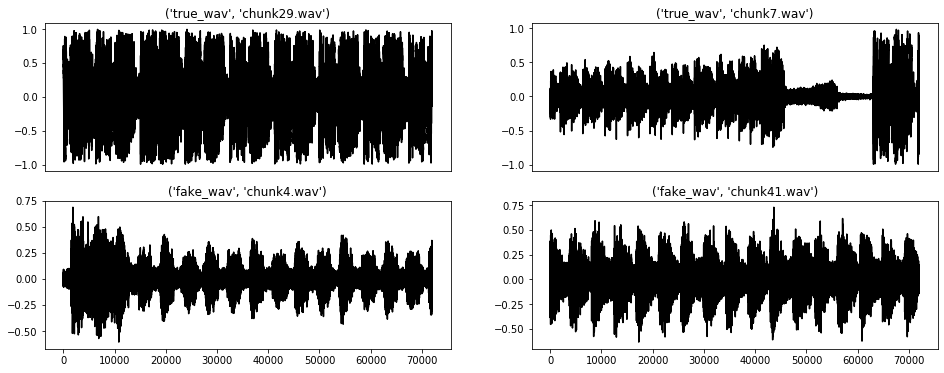

In [5]:
# get all wav files
fps = glob.glob('_data/**/*.wav', recursive=True)
fps_random = []
np.random.seed(9)

# setup subplot 
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

# plot some audio waveforms
for r in range(nrows):
    for c in range(ncols):
        fp_random = fps[np.random.randint(len(fps))]
        audio, sr = librosa.core.load(fp_random, sr=None)
        ax[r][c].plot(audio, c='k')
        # ax[r][c].axis('off')
        ax[r][c].set_title(Path(fp_random).parts[-2:])
        if r == 0:
            ax[r][c].set_xticks([])
        # save random audio filepaths
        fps_random.append(fp_random)

Melspec shape: (64, 282)
Stft shape: (1025, 282)
Total data points in mel-spectrogram: 18048
Total data points in stft-spectrogram: 289050
-> Data Reduction by factor: 16.015625



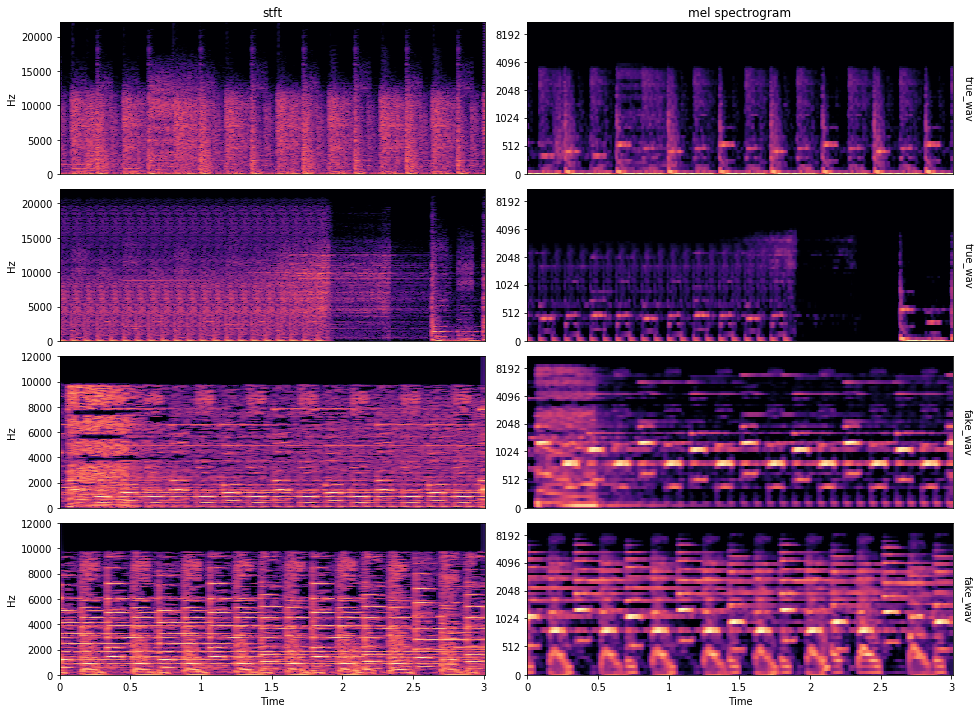

In [6]:
# setup subplot 
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# plot some audio waveforms
for i, fp_random in enumerate(fps_random):
    audio, sr = librosa.core.load(fp_random, sr=None)

    # calculate stft
    stft = librosa.stft(audio, n_fft=2048, hop_length=256, win_length=2048)
    
    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio, n_fft=2048, hop_length=256, n_mels=64, fmax=int(sr/2))
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # calculate magnitude and scale to dB
    magspec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    # plot with librosa
    librosa.display.specshow(magspec, x_axis='time', y_axis='linear', sr=sr, hop_length=256, ax=ax[i][0])
    librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=sr, hop_length=256, ax=ax[i][1])
    
    # adjustments
    # ax[i][1].set_yticks([])
    ax[i][1].set_ylabel(Path(fp_random).parts[-2], rotation=270, labelpad=20)
    ax[i][1].yaxis.set_label_position("right")
    
    # settings for all axises but bottom ones
    if not i == len(fps_random) - 1:
        ax[i][0].set_xticks([])
        ax[i][1].set_xticks([])
        ax[i][0].set_xlabel('')
        ax[i][1].set_xlabel('')
    
    # settings for upper axises
    if i == 0:
        ax[i][0].set_title('stft')
        ax[i][1].set_title('mel spectrogram')   

# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.1, wspace=0.1)

print('Melspec shape: %s' % (str(melspec.shape)))
print('Stft shape: %s' % (str(stft.shape)))
print(f'Total data points in mel-spectrogram: {melspec.shape[0]*melspec.shape[1]}')
print(f'Total data points in stft-spectrogram: {stft.shape[0]*stft.shape[1]}')
print(f'-> Data Reduction by factor: {(stft.shape[0]*stft.shape[1]) / (melspec.shape[0]*melspec.shape[1])}')
print()

In [7]:
config = {'sr': 44100, 
          'audio_length': 3,
          'mono': True,
          'n_mels': 64,
          'n_fft': 2048,
          'hop_length': 256,
          'win_length': 2048,
          'window': 'hann',
          'center': True,
          'pad_mode': 'reflect',
          'power': 2.0,
          'classes': classes
         }

# save number of frames from length in samples divided by fft hop length
config['n_frames'] = int(config['sr']*config['audio_length']/config['hop_length']) + 1

# save input shape for model
config['input_shape'] = (config['n_mels'], config['n_frames'], 1)

# save config 
with open('DLNet_config.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

# pretty print json
print(json.dumps(config, indent=4))

{
    "sr": 44100,
    "audio_length": 3,
    "mono": true,
    "n_mels": 64,
    "n_fft": 2048,
    "hop_length": 256,
    "win_length": 2048,
    "window": "hann",
    "center": true,
    "pad_mode": "reflect",
    "power": 2.0,
    "classes": [
        "processed",
        "test",
        "train"
    ],
    "n_frames": 517,
    "input_shape": [
        64,
        517,
        1
    ]
}


In [24]:
# generate mel-filter matrix
mel_filter = librosa.filters.mel(config['sr'], 
                                 config['n_fft'], 
                                 n_mels=config['n_mels'], 
                                 fmin=0.0, 
                                 fmax=None, 
                                 htk=False, 
                                 norm='slaney', 
                                 dtype=np.float32)


def folder_name_to_one_hot(file_path):
    
    label = Path(file_path).parts[-1]
    label_idx = classes.index(label)
    
    # get one hot encoded array
    one_hot = tf.one_hot(label_idx, len(config['classes']), on_value=None, off_value=None, 
                         axis=None, dtype=tf.uint8, name=None)
    return one_hot

TypeError: mel() got an unexpected keyword argument 'dtype'